lovanto george

In [37]:
%%capture
# required libraries

%pip install numpy pandas tensorflow scikit-learn seaborn matplotlib obspy keras 

import pandas as pd
import numpy as np
import seaborn as sns
from obspy import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from obspy.signal.invsim import cosine_taper
from scipy.signal import welch
from obspy.signal.freqattributes import spectrum

In [38]:
import os

catalog = pd.read_csv('data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
training_data = {}

for index, row in catalog.iterrows():
    try:
        file_path = f'data/lunar/training/data/S12_GradeA/{row.filename}.mseed'
        
        # Check if the file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        # Read the data
        data = read(file_path)
        
        # Ensure the necessary columns are present
        if 'time_rel(sec)' not in row or 'mq_type' not in row:
            raise KeyError("Missing required columns in the row data")
        
        # Add to training_data
        training_data[row.evid] = {
            'data': data,
            'rel_time': row['time_rel(sec)'],
            'type': row['mq_type']
        }
    
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except KeyError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Error: File not found: data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


In [39]:
# first let's peek at a sample of the seismic events, to determine how large we should make the windows.

events = training_data.keys()

WINDOW = 10000 # 10,000 secs for training window

In [40]:
nfft = 1024  # Number of points in FFT
width = 3 

def convert_to_low_res(tr):
    minfreq = 0.5
    maxfreq = 1.0
    
    # Going to create a separate trace for the filter data
    trace = tr.copy()
    tr.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    
    # Step 2: Define your parameters
    fs = trace.stats.sampling_rate  # Sampling frequency
    n_seconds = int(trace.stats.npts / fs)  # Total number of seconds
    n_bins = 10  # Number of frequency bands
    freq_bins = np.linspace(0, fs / 2, n_bins + 1)  # Define frequency bands
    amplitudes = np.zeros((n_seconds, n_bins))  # Prepare an array to store amplitudes
    
    # Step 3: Process the data for each second
    for i in range(int(n_seconds/width)):
        start = i*width
        segment = trace.data[int(start * fs):int((start + width) * fs)]
        
        # # Apply a taper to minimize edge effects
        # taper = cosine_taper(len(segment), 0.1)  # 10% taper
        # segment *= taper
    
        # Compute the PSD using Welch's method
        f, Pxx = welch(segment, fs, nperseg=fs * width, nfft=nfft, scaling='density')
    
        # Step 4: Aggregate the data into frequency bins
        for i in range(n_bins):
            mask = (f >= freq_bins[i]) & (f < freq_bins[i + 1])
            amplitudes[start, i] = np.sqrt(np.sum(Pxx[mask]))

    return amplitudes

In [41]:
# pull from reflextion

for event in events:
    training_data[event]['data_low_res'] = np.loadtxt('processed_data/low_res_' + event)

In [42]:
training_data

{'evid00002': {'data': 1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples,
  'rel_time': 73500.0,
  'type': 'impact_mq',
  'data_low_res': array([[1.39614550e-53, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.37377639e-49, 0.00000000e+00, 1.44382554e-48, ...,
          0.00000000e+00, 1.26190948e-49, 0.00000000e+00],
         [2.32519732e-48, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [2.27910084e-33, 0.00000000e+00, 4.59994192e-33, ...,
          0.00000000e+00, 1.32291524e-34, 0.00000000e+00],
         [1.47906305e-33, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.15332773e-33, 0.00000000e+00, 2.27620189e-33, ...,
          0.00000000e+00, 6.78188916e-35, 0.00000000e+00]])},
 'evid00003': {'data': 1 Trace(s) in Stream:

In [47]:
import numpy as np

# Initialize lists to hold features and labels
X = []
y = []

# Determine the maximum length of the feature arrays
max_length = max(training_data[event]['data_low_res'].size for event in training_data)

# Iterate over each event to extract features and labels
for event in training_data:
    # Extract the low-resolution data as features
    features = training_data[event]['data_low_res'].flatten()  # Flatten the 2D array to 1D
    
    # Pad the features array to the maximum length
    padded_features = np.pad(features, (0, max_length - features.size), 'constant')
    
    # Reshape to add an extra dimension
    padded_features = padded_features.reshape(-1, 1)
    
    X.append(padded_features)
    
    # Extract the event type as the label
    label = training_data[event]['type']
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")


Feature matrix shape: (75, 864040, 1)
Label vector shape: (75,)


In [48]:
from collections import Counter

print(f"Original label distribution: {Counter(y)}")


Original label distribution: Counter({'impact_mq': 63, 'deep_mq': 9, 'shallow_mq': 3})


In [51]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Initialize lists to hold features and labels
X = []
y = []

# Determine the maximum length of the feature arrays
max_length = max(training_data[event]['data_low_res'].size for event in training_data)

# Iterate over each event to extract features and labels
for event in training_data:
    # Extract the low-resolution data as features
    features = training_data[event]['data_low_res'].flatten()  # Flatten the 2D array to 1D
    
    # Pad the features array to the maximum length
    padded_features = np.pad(features, (0, max_length - features.size), 'constant')
    
    # Reshape to add an extra dimension
    padded_features = padded_features.reshape(-1, 1)
    
    X.append(padded_features)
    
    # Extract the event type as the label
    label = training_data[event]['type']
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Ensure X is of type float32
X = X.astype('float32')

# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Determine the number of samples in the minority class
minority_class_count = min(Counter(y).values())

# Set n_neighbors to a value less than or equal to the minority class count - 1
n_neighbors = min(5, minority_class_count - 1)

# Reshape X to 2D for SMOTE
X_reshaped = X.reshape(len(X), -1)

# Apply SMOTE with the adjusted n_neighbors
smote = SMOTE(k_neighbors=n_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

# Reshape X_resampled back to 3D
X_resampled = X_resampled.reshape(-1, max_length, 1)

print(f"Original dataset shape: {X.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")
print(f"Original label distribution: {Counter(y)}")
print(f"Resampled label distribution: {Counter(y_resampled)}")

# Now you can use X_resampled and y_resampled to train your model


Original dataset shape: (75, 864040, 1)
Resampled dataset shape: (189, 864040, 1)
Original label distribution: Counter({1: 63, 0: 9, 2: 3})
Resampled label distribution: Counter({1: 63, 0: 63, 2: 63})


In [52]:
print("X_resampled shape: " + str(X_resampled.shape))
print("y_resampled shape: " + str(y_resampled.shape))

X_resampled shape: (189, 864040, 1)
y_resampled shape: (189,)


In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=69)

In [54]:
print(X_train.dtype)
print(Y_train.dtype)


float32
int64


In [58]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)

X_train = X_train.astype('float32')

In [59]:
print(X_train.shape)

(170, 864040, 1)


In [61]:
print(np.unique(Y_train))


[0 1 2]


In [62]:
# Option 1: Filter out samples with label 2
mask = Y_train != 2
X_train = X_train[mask]
Y_train = Y_train[mask]

In [63]:
from BinaryTransformClassify import BinaryTransformClassifier 

# Create an instance of the BinaryTransformClassifier class
btc = BinaryTransformClassifier(X_train.shape[1:])

# Train the classifier
history = btc.train(50, X_train, Y_train, batch_size=1)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - loss: 0.6937 - sparse_categorical_accuracy: 0.5002 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4348 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - loss: 0.6936 - sparse_categorical_accuracy: 0.3588 - val_loss: 0.6945 - val_sparse_categorical_accuracy: 0.4348 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5380 - val_loss: 0.6943 - val_sparse_categorical_accuracy: 0.4348 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.6940 - sparse_categorical_accuracy: 0.4799 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.4348 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.6933 - sparse_categorical_accuracy: 0.5151 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.5652 - learning_rate: 0.0010
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - lo

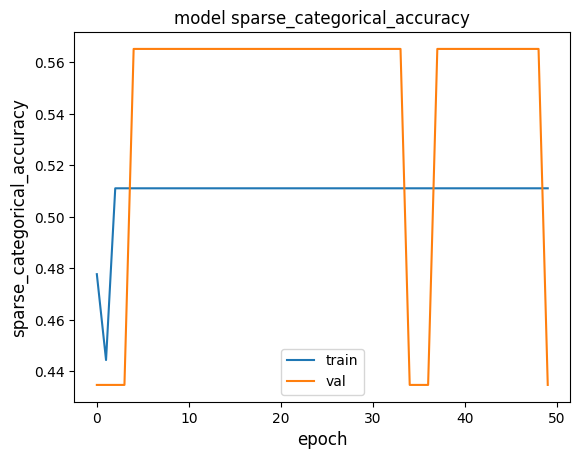

In [64]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [67]:
mask = Y_test != 2
X_test = X_test[mask]
Y_test = Y_test[mask]

btc.evaluate(X_test, Y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.7286 - sparse_categorical_accuracy: 0.4615


[0.7285658717155457, 0.4615384638309479]